In [2]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc
gc.collect()  #

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import warnings
warnings.filterwarnings("ignore")


import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [4]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)

(53275, 5184)


In [5]:
day=4
df_day = df_ae[df_ae['day'].isin([day])]
X_day = np.asarray(df_day.loc[:,"0":"5183"])

Normalizer_ = Normalizer().fit(X_day)
X = Normalizer_.transform(X_day)

In [8]:
X.shape

(4084, 5184)

Computing PacMAP features
PacMAP completed in 98.66 secs.
Creating KDTree...
KDTree completed in 94.01 secs.
Computing Graph...
Graph computed with 4084 nodes and 228721 edges.
Aplying Kamada-Kawai Layout...
Kamada-Kawai completed in 1225.95 secs.
Graph ploted


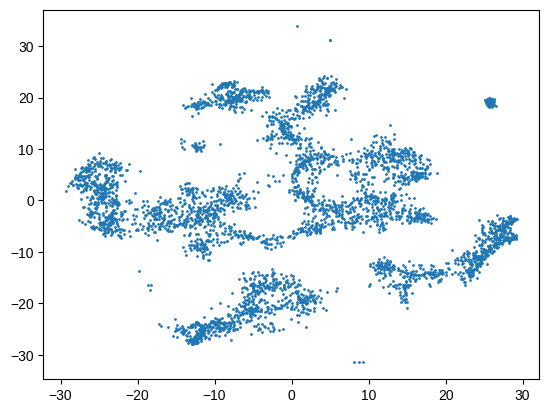

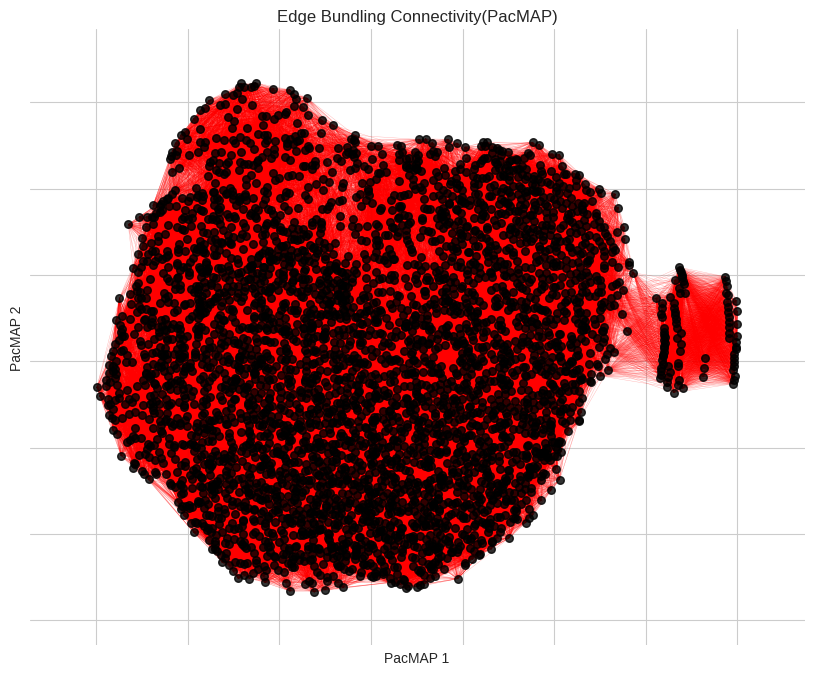

In [7]:
import numpy as np
import pacmap
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import mplcyberpunk  # Estilo visual mejorado
from sklearn.datasets import make_blobs
from scipy.spatial import KDTree
from networkx.drawing.layout import kamada_kawai_layout
import time


# 🔹 Aplicar PacMAP para reducir a 2D
print("Computing PacMAP features")
start_time = time.time()
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print(f"PacMAP completed in {time.time() - start_time:.2f} secs.")

plt.figure()
plt.scatter(X_pacmap[:,0], X_pacmap[:,1], s=1, alpha=1)

# 🔹 Construir grafo de conectividad con KDTree
print("Creating KDTree...")
start_time = time.time()
tree = KDTree(X)  
neighbors = tree.query(X, k=75)[1]  # Obtener los 75 vecinos más cercanos
print(f"KDTree completed in {time.time() - start_time:.2f} secs.")


# 🔹 Crear el grafo en NetworkX
print("Computing Graph...")
G = nx.Graph()
for i in range(len(X)):
    for j in neighbors[i][1:]:  # Evitar conectar un nodo consigo mismo
        G.add_edge(i, j)
print(f"Graph computed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



# 🔹 Aplicar Force-Directed Edge Bundling con Kamada-Kawai layout
print("Aplying Kamada-Kawai Layout...")
start_time = time.time()
pos = {i: X_pacmap[i] for i in range(len(X))}
pos_bundle = kamada_kawai_layout(G, pos=pos)  # Edge Bundling
print(f"Kamada-Kawai completed in {time.time() - start_time:.2f} secs.")


# 🔹 Graficar con mejor estilo
plt.style.use("seaborn-whitegrid")  # Activar el estilo seaborn-whitegrid
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_bundle, node_size=30, node_color='black', alpha=0.8)
nx.draw_networkx_edges(G, pos_bundle, width=0.3, edge_color="red", alpha=0.3)

print("Graph ploted")

# 🔹 Efectos visuales
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title("Edge Bundling Connectivity(PacMAP)")
plt.xlabel("PacMAP 1")
plt.ylabel("PacMAP 2")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import ConvexHull

# 🔹 Simulación de coordenadas de grabadoras en Sudamérica
np.random.seed(42)
n_grabadoras = 10
n_audios = 2000  # 🔥 Ahora usamos 2000 muestras

# Coordenadas aleatorias de grabadoras en Sudamérica (Brasil - Argentina)
coordenadas_grabadoras = {
    i: (np.random.uniform(-20, -5), np.random.uniform(-55, -40))  # Latitud y longitud
    for i in range(n_grabadoras)
}

# 🔹 Asignar audios a grabadoras
grabadora_id = np.random.choice(list(coordenadas_grabadoras.keys()), size=n_audios)

# 🔹 Generar datos ficticios de espectrogramas (128 dimensiones)
X_audio = np.random.rand(n_audios, 128)

# 🔹 Construcción de grafo de conectividad entre audios
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

# 🔹 Construcción de grafo de conectividad entre grabadoras
G_places = nx.Graph()
for i in range(n_grabadoras):
    G_places.add_node(i, pos=coordenadas_grabadoras[i])  # Añadir nodos con ubicación geográfica

# 🔹 Conectar grabadoras si tienen audios similares
for i, j in G_audio.edges():
    g1, g2 = grabadora_id[i], grabadora_id[j]
    if g1 != g2:  # Solo conectamos si son grabadoras diferentes
        if G_places.has_edge(g1, g2):
            G_places[g1][g2]["weight"] += 1
        else:
            G_places.add_edge(g1, g2, weight=1)

# 🔹 Convertir nodos a GeoDataFrame
grabadoras_gdf = gpd.GeoDataFrame(
    {"id": list(G_places.nodes())},
    geometry=gpd.points_from_xy(
        [coordenadas_grabadoras[i][1] for i in G_places.nodes()],  # Longitud
        [coordenadas_grabadoras[i][0] for i in G_places.nodes()]   # Latitud
    ),
    crs="EPSG:4326"
)

# 🔹 Transformar posiciones del grafo para Geopandas
pos_geo = {i: (grabadoras_gdf.geometry.x.iloc[i], grabadoras_gdf.geometry.y.iloc[i]) for i in G_places.nodes()}

# 🔹 Aplicar Edge Bundling para reducir el cruce de líneas
def edge_bundle(G, pos, alpha=0.3, segments=10):
    """ Suaviza las conexiones entre nodos con Edge Bundling """
    new_edges = []
    for u, v, data in G.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # 🔹 Generamos puntos intermedios para suavizar la curva
        x = np.linspace(x1, x2, segments)
        y = np.linspace(y1, y2, segments)
        
        # 🔹 Ajustamos el peso para que las líneas sean más delgadas
        weight = max(0.2, data["weight"] * 0.1)  
        
        new_edges.append((x, y, weight))
    
    return new_edges

# 🔹 Obtener las curvas de edge bundling
bundled_edges = edge_bundle(G_places, pos_geo, alpha=0.3, segments=20)

# 🔹 Graficar el grafo con Edge Bundling
fig, ax = plt.subplots(figsize=(10, 6))

# 🔹 Dibujar conexiones suavizadas
for x, y, weight in bundled_edges:
    ax.plot(x, y, color="red", linewidth=weight, alpha=0.4)

# 🔹 Dibujar nodos (grabadoras)
grabadoras_gdf.plot(ax=ax, color="blue", markersize=80, edgecolor="black", label="Grabadoras")

# 🔹 Dibujar Convex Hull para resaltar el área ocupada por las grabadoras
points = np.array([pos_geo[i] for i in G_places.nodes()])
hull = ConvexHull(points)
hull_path = points[hull.vertices]
ax.fill(hull_path[:, 0], hull_path[:, 1], color="lightgray", alpha=0.3, label="Área de Grabadoras")

# 🔹 Ajustar los límites del gráfico
ax.set_xlim(grabadoras_gdf.geometry.x.min() - 2, grabadoras_gdf.geometry.x.max() + 2)
ax.set_ylim(grabadoras_gdf.geometry.y.min() - 2, grabadoras_gdf.geometry.y.max() + 2)

# 🔹 Ajustes finales
plt.title("Conectividad entre Lugares Basada en Similitud Acústica (Edge Bundling)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from shapely.geometry import Point, LineString

# 1️⃣ Simulación de datos: DataFrame con 1000 audios
np.random.seed(42)
n_audios = 1000
n_features = 512
n_grabadoras = 20

grabadoras = np.random.randint(0, n_grabadoras, n_audios)  # Asignar cada audio a una grabadora
X_audio = np.random.rand(n_audios, n_features)  # Simular características de audio

# Crear DataFrame
df = pd.DataFrame(X_audio, columns=[f'feat_{i}' for i in range(n_features)])
df['grabadora'] = grabadoras

# 2️⃣ Calcular la matriz de distancia/similitud entre audios
distance_matrix = squareform(pdist(X_audio, metric="euclidean"))
sim_matrix = np.exp(-distance_matrix / np.std(distance_matrix))  # Normalizar mejor la similitud

# 3️⃣ Calcular la entropía de cada audio
node_entropy = np.array([entropy(sim_matrix[i] + 1e-10) for i in range(n_audios)])  # Evitar log(0)

# 4️⃣ Definir umbral de similitud para conexiones entre audios
threshold = np.percentile(sim_matrix, 90)  # Usar percentil sobre sim_matrix en lugar de entropía
connectivity_matrix = sim_matrix >= threshold  # Conectar audios con alta similitud

# 5️⃣ Crear grafo de conectividad de audios
G_audio = nx.Graph()
for i in range(n_audios):
    G_audio.add_node(i, grabadora=df['grabadora'][i])
    for j in range(i + 1, n_audios):
        if connectivity_matrix[i, j]:
            G_audio.add_edge(i, j)

# Verificar si el grafo tiene nodos y conexiones
print(f"Nodos en G_audio: {G_audio.number_of_nodes()}, Aristas en G_audio: {G_audio.number_of_edges()}")

# 6️⃣ Construir conectividad entre grabadoras a partir del grafo de audios
G_grabadoras = nx.Graph()
for i, j in G_audio.edges():
    grabadora_i = df['grabadora'][i]
    grabadora_j = df['grabadora'][j]
    if grabadora_i != grabadora_j:
        if G_grabadoras.has_edge(grabadora_i, grabadora_j):
            G_grabadoras[grabadora_i][grabadora_j]['weight'] += 1
        else:
            G_grabadoras.add_edge(grabadora_i, grabadora_j, weight=1)

# 7️⃣ Simulación de coordenadas de grabadoras para visualización
coordenadas = {i: Point(np.random.uniform(-100, 100), np.random.uniform(-100, 100)) for i in range(n_grabadoras)}
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas.keys()), "geometry": list(coordenadas.values())})

# 8️⃣ Visualización del mapa de conectividad entre grabadoras
fig, ax = plt.subplots(figsize=(10, 6))
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Dibujar conexiones entre grabadoras
for i, j in G_grabadoras.edges():
    if i in coordenadas and j in coordenadas:
        line = LineString([coordenadas[i], coordenadas[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'] * 0.001)

ax.set_title("Mapa de conectividad entre grabadoras basado en Graph Entropy de Audios")
plt.legend()
plt.show()



In [ ]:
sim_matrix